In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

city = 'AL_Maceio'

Using TensorFlow backend.


In [2]:
def getFileNameIn(path):
    files_names = []
    for dirname, dirnames, filenames in os.walk(path):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            files_names.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            files_names.append(os.path.join(dirname, filename))
        
        return files_names

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.fillna(0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
    
    output_path = '../data_out/' + data_input_path[11:]
    # save file
    dataset.to_csv(output_path)
    
    return output_path

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

In [6]:
# plot each column in a graph
def plot_columns(dataset, values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler * inv_y_hat
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler * inv_y_test
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests, days_to_predict):
    temps_splited = splitTemperature(y_hats, y_tests, city)
    y_hats_max = temps_splited[0]
    y_tests_max = temps_splited[1]
    y_hats_min = temps_splited[2]
    y_tests_min = temps_splited[3]
    
    errors_max = abs(np.subtract(y_hats_max,y_tests_max))
    errors_min = abs(np.subtract(y_hats_min,y_tests_min))
    
    print('Maximum temperatures metrics')
    printMetrics(errors_max, 'max', city)
    day_errors(days_to_predict, errors_max, city)
    accuracy(errors_max, city)
    
    print('\nMinimum temperatures metrics')
    printMetrics(errors_min, 'min', city)
    day_errors(days_to_predict, errors_min, city)
    accuracy(errors_min, city)

In [12]:
def splitTemperature(y_hats, y_tests, city):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    for y in y_hats:
        y_hats_max.append(y[0])
        y_hats_min.append(y[1])
        
    for y in y_tests:
        y_tests_max.append(y[0])
        y_tests_min.append(y[1])
    
    file_path = '../results/'+city+'_mean_normalization_predictions_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()
    
    for i,j,k,l in zip(y_hats_max, y_tests_max, y_hats_min, y_tests_min):
        content.append('{},{},{},{}\n'.format(i,j,k,l))

    file = open(file_path, 'w')
    file.writelines(content)
    file.close()
    
    return [y_hats_max, y_tests_max, y_hats_min, y_tests_min]

In [13]:
def printMetrics(errors, temperature, city):
    mse = np.mean(np.square(errors))
    std = np.std(errors)
    meanAbsolutError = np.mean(errors)
    medianAbsoluteError = np.median(errors)
    
    file_path = '../results/'+city+'_mean_normalization_metrics_results.csv'
    if temperature == 'max':
        file = open(file_path, 'r')
        content = file.readlines()

        content.append('{},{},{},{}\n'.format(mse,std,meanAbsolutError,medianAbsoluteError))

        file = open(file_path, 'w')
        file.writelines(content)
        file.close()
    elif temperature == 'min':
        file = open(file_path, 'r')
        content = file.readlines()
        
        content[1] = content[1].replace('\n', ',')+'{},{},{},{}\n'.format(mse,std,meanAbsolutError,medianAbsoluteError)

        file = open(file_path, 'w')
        file.writelines(content)
        file.close()
    
    print('Test MEAN-SQUARED-ERROR ------------ {:.4}'.format(mse))
    print('Test STANDART-DEVIATION ------------ {:.4}'.format(std))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError))

In [14]:
def accuracy(errors, city):
    j = 1
    sum_percentual = 0
    accuracys = []
    sets = []
    
    print('\nAccuracy')
    while sum_percentual <= 99:
        count = 0
        n = len(errors)
        
        for error in errors:
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = (count/n)*100
        sum_percentual += percentual
        if percentual > 0:
            accuracys.append(percentual)
            sets.append('({}, {}]'.format(j-1, j))
            print('{:.2f}% of predictions missed between ({}, {}] point(s)'.format(percentual, j-1, j))
        j += 1
    print('\n')
    
    file_path = '../results/'+city+'_mean_normalization_accuracy_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()

    for i,j in zip(accuracys, sets):
        content.append('{},{}\n'.format(i,j))

    file = open(file_path, 'w')
    file.writelines(content)
    file.close()

In [15]:
def day_errors(days_to_predict, errors, city):
    i = 0
    
    file_path = '../results/'+city+'_mean_normalization_predictions_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()
    
    print('\nErrors')
    for error in errors:
        content[i+1] = content[i+1].replace('\n', ',')+'{}\n'.format(error)
        print('{} = {}'.format(days_to_predict[29-i],error))
        i += 1
    
    file = open(file_path, 'w')
    file.writelines(content)
    file.close()

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2014-01-01           0.0        30.9        22.2       10.5               3.0   
2014-01-02           0.0        30.9        22.3       10.4               4.6   
2014-01-03           0.0        31.1        21.1        8.2               3.2   
2014-01-04           0.0        32.4        22.8       10.6               4.6   
2014-01-05           0.0        30.6        21.9        7.9               4.4   
...                  ...         ...         ...        ...               ...   
2018-12-27           0.0        33.4        23.6        9.9               2.8   
2018-12-28           0.0        33.0        23.6        9.6               2.8   
2018-12-29           0.0        33.2        23.4        8.7               2.8   
2018-12-30           0.0        33.0        23.1        3.4               2.8   
2018-12-31           0.0    

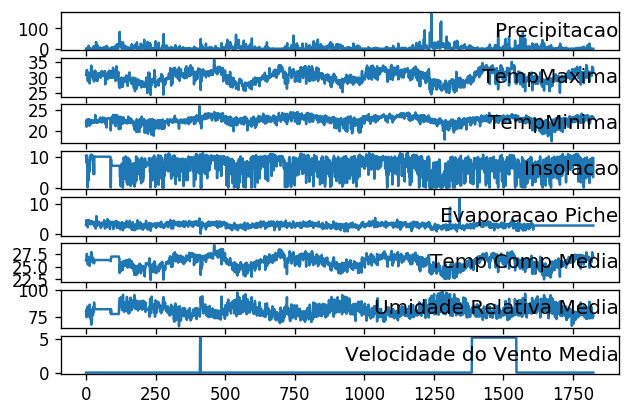

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4080 - mean_squared_error: 0.4442 - val_loss: 0.0247 - val_mean_squared_error: 6.1460e-04
Epoch 2/1000
 - 0s - loss: 0.0610 - mean_squared_error: 0.0068 - val_loss: 0.0525 - val_mean_squared_error: 0.0046
Epoch 3/1000
 - 0s - loss: 0.0507 - mean_squared_error: 0.0045 - val_loss: 0.0751 - val_mean_squared_error: 0.0093
Epoch 4/1000
 - 1s - loss: 0.0498 - mean_squared_error: 0.0043 - val_loss: 0.0621 - val_mean_squared_error: 0.0066
Epoch 5/1000
 - 0s - loss: 0.0480 - mean_squared_error: 0.0040 - val_loss: 0.0695 - val_mean_squared_error: 0.0070
Epoch 6/1000
 - 0s - loss: 0.0462 - mean_squared_error: 0.0038 - val_loss: 0.0680 - val_mean_squared_error: 0.0075
Epoch 7/1000
 - 0s - loss: 0.0451 - mean_squared_error: 0.0036 - val_loss: 0.0603 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 1s - loss: 0.0444 - mean_squared_error: 0.0036 - val_loss: 0.0763 - val_mean_squared_error: 0.0083

Epoch 00008: ReduceLROnPlateau

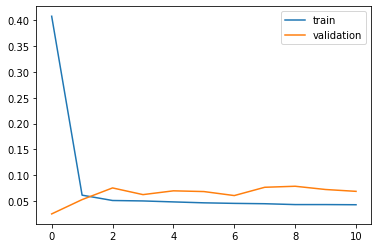


predict: [[33.42034439 22.38068071]]
real:      [[32.2 23.3]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4006 - mean_squared_error: 0.3131 - val_loss: 0.0440 - val_mean_squared_error: 0.0019
Epoch 2/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0076 - val_loss: 0.0665 - val_mean_squared_error: 0.0050
Epoch 3/1000
 - 0s - loss: 0.0513 - mean_squared_error: 0.0047 - val_loss: 0.0644 - val_mean_squared_error: 0.0065
Epoch 4/1000
 - 1s - loss: 0.0490 - mean_squared_error: 0.0043 - val_loss: 0.0762 - val_mean_squared_error: 0.0080
Epoch 5/1000
 - 0s - loss: 0.0476 - mean_squared_error: 0.0041 - val_loss: 0.0811 - val_mean_squared_error: 0.0092
Epoch 6/1000
 - 1s - loss: 0.0462 - mean_squared_error: 0.0039 - val_loss: 0.0701 - val_mean_squared_error: 0.0072
Epoch 7/1000
 - 1s - loss: 0.0448 - mean_squared_error: 0.0036 - val_loss: 0.0703 - val_mean_squared_error: 0.0086
Epoch 8/1000
 - 0s - loss: 0.0438 - mean_squared_error: 0.0034 - val_loss: 0.0708 - va

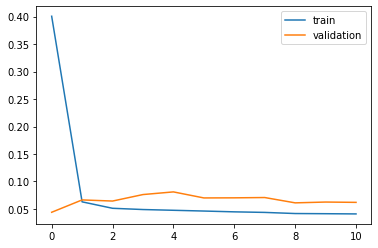


predict: [[33.5245993  22.20282694]]
real:      [[33.  23.1]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1252 - mean_squared_error: 1.4037 - val_loss: 0.6439 - val_mean_squared_error: 0.4158
Epoch 2/1000
 - 0s - loss: 0.1806 - mean_squared_error: 0.0587 - val_loss: 0.1200 - val_mean_squared_error: 0.0146
Epoch 3/1000
 - 0s - loss: 0.0551 - mean_squared_error: 0.0048 - val_loss: 0.0891 - val_mean_squared_error: 0.0099
Epoch 4/1000
 - 1s - loss: 0.0494 - mean_squared_error: 0.0041 - val_loss: 0.0657 - val_mean_squared_error: 0.0060
Epoch 5/1000
 - 1s - loss: 0.0470 - mean_squared_error: 0.0039 - val_loss: 0.0784 - val_mean_squared_error: 0.0080
Epoch 6/1000
 - 1s - loss: 0.0467 - mean_squared_error: 0.0039 - val_loss: 0.0835 - val_mean_squared_error: 0.0092
Epoch 7/1000
 - 1s - loss: 0.0454 - mean_squared_error: 0.0036 - val_loss: 0.0746 - val_mean_squared_error: 0.0085
Epoch 8/1000
 - 1s - loss: 0.0455 - mean_squared_error: 0.0037 - val_loss: 0.0772 - va

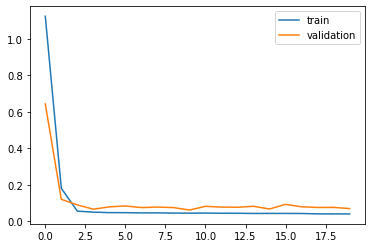


predict: [[30.89299651 23.30260393]]
real:      [[33.2 23.4]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.1768 - mean_squared_error: 0.0756 - val_loss: 0.0961 - val_mean_squared_error: 0.0131
Epoch 2/1000
 - 1s - loss: 0.0548 - mean_squared_error: 0.0053 - val_loss: 0.0775 - val_mean_squared_error: 0.0073
Epoch 3/1000
 - 1s - loss: 0.0485 - mean_squared_error: 0.0043 - val_loss: 0.0770 - val_mean_squared_error: 0.0084
Epoch 4/1000
 - 1s - loss: 0.0464 - mean_squared_error: 0.0039 - val_loss: 0.0715 - val_mean_squared_error: 0.0064
Epoch 5/1000
 - 1s - loss: 0.0444 - mean_squared_error: 0.0036 - val_loss: 0.0588 - val_mean_squared_error: 0.0047
Epoch 6/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0033 - val_loss: 0.0903 - val_mean_squared_error: 0.0096
Epoch 7/1000
 - 1s - loss: 0.0415 - mean_squared_error: 0.0031 - val_loss: 0.0859 - val_mean_squared_error: 0.0087
Epoch 8/1000
 - 1s - loss: 0.0418 - mean_squared_error: 0.0030 - val_loss: 0.0471 - va

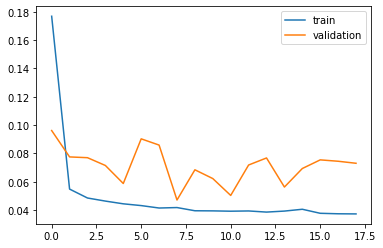


predict: [[31.4593011  23.57387022]]
real:      [[33.  23.6]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3671 - mean_squared_error: 0.3419 - val_loss: 0.0435 - val_mean_squared_error: 0.0028
Epoch 2/1000
 - 1s - loss: 0.0552 - mean_squared_error: 0.0053 - val_loss: 0.0690 - val_mean_squared_error: 0.0060
Epoch 3/1000
 - 1s - loss: 0.0456 - mean_squared_error: 0.0037 - val_loss: 0.0521 - val_mean_squared_error: 0.0032
Epoch 4/1000
 - 1s - loss: 0.0433 - mean_squared_error: 0.0034 - val_loss: 0.0552 - val_mean_squared_error: 0.0036
Epoch 5/1000
 - 1s - loss: 0.0416 - mean_squared_error: 0.0031 - val_loss: 0.0579 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 1s - loss: 0.0399 - mean_squared_error: 0.0029 - val_loss: 0.0517 - val_mean_squared_error: 0.0028
Epoch 7/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0030 - val_loss: 0.0544 - val_mean_squared_error: 0.0042
Epoch 8/1000
 - 1s - loss: 0.0405 - mean_squared_error: 0.0029 - val_loss: 0.0664 - va

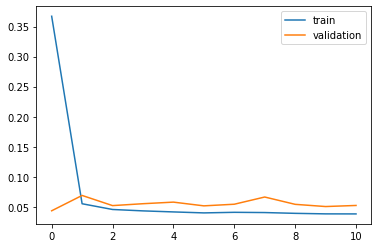


predict: [[31.95986199 22.00230085]]
real:      [[33.4 23.6]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7520 - mean_squared_error: 0.7334 - val_loss: 0.2061 - val_mean_squared_error: 0.0776
Epoch 2/1000
 - 1s - loss: 0.0926 - mean_squared_error: 0.0149 - val_loss: 0.0524 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 0s - loss: 0.0514 - mean_squared_error: 0.0047 - val_loss: 0.0106 - val_mean_squared_error: 1.4497e-04
Epoch 4/1000
 - 0s - loss: 0.0487 - mean_squared_error: 0.0043 - val_loss: 0.0144 - val_mean_squared_error: 2.2065e-04
Epoch 5/1000
 - 1s - loss: 0.0464 - mean_squared_error: 0.0038 - val_loss: 0.0147 - val_mean_squared_error: 3.3829e-04
Epoch 6/1000
 - 1s - loss: 0.0448 - mean_squared_error: 0.0035 - val_loss: 0.0186 - val_mean_squared_error: 3.5442e-04
Epoch 7/1000
 - 1s - loss: 0.0438 - mean_squared_error: 0.0034 - val_loss: 0.0277 - val_mean_squared_error: 8.9209e-04
Epoch 8/1000
 - 1s - loss: 0.0426 - mean_squared_error: 0.0032 - v

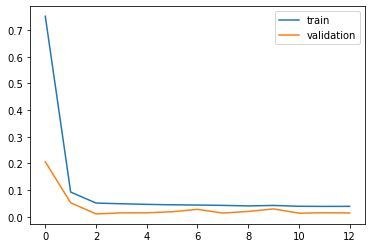


predict: [[30.44697994 22.91543883]]
real:      [[32.  23.5]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4549 - mean_squared_error: 0.4157 - val_loss: 0.0876 - val_mean_squared_error: 0.0113
Epoch 2/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0073 - val_loss: 0.0244 - val_mean_squared_error: 5.9886e-04
Epoch 3/1000
 - 1s - loss: 0.0477 - mean_squared_error: 0.0041 - val_loss: 0.0183 - val_mean_squared_error: 3.4435e-04
Epoch 4/1000
 - 1s - loss: 0.0468 - mean_squared_error: 0.0038 - val_loss: 0.0313 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 1s - loss: 0.0464 - mean_squared_error: 0.0038 - val_loss: 0.0285 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0459 - mean_squared_error: 0.0037 - val_loss: 0.0122 - val_mean_squared_error: 1.6920e-04
Epoch 7/1000
 - 0s - loss: 0.0449 - mean_squared_error: 0.0036 - val_loss: 0.0369 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 0s - loss: 0.0455 - mean_squared_error: 0.0036 - val_loss:

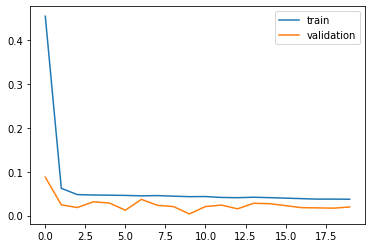


predict: [[30.34275786 23.36330326]]
real:      [[30.5 23.6]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4851 - mean_squared_error: 0.6219 - val_loss: 0.0741 - val_mean_squared_error: 0.0096
Epoch 2/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0070 - val_loss: 0.0287 - val_mean_squared_error: 8.8782e-04
Epoch 3/1000
 - 1s - loss: 0.0477 - mean_squared_error: 0.0039 - val_loss: 0.0106 - val_mean_squared_error: 2.1279e-04
Epoch 4/1000
 - 1s - loss: 0.0473 - mean_squared_error: 0.0039 - val_loss: 0.0219 - val_mean_squared_error: 5.4236e-04
Epoch 5/1000
 - 0s - loss: 0.0462 - mean_squared_error: 0.0037 - val_loss: 0.0177 - val_mean_squared_error: 4.0068e-04
Epoch 6/1000
 - 0s - loss: 0.0452 - mean_squared_error: 0.0036 - val_loss: 0.0091 - val_mean_squared_error: 1.3428e-04
Epoch 7/1000
 - 0s - loss: 0.0448 - mean_squared_error: 0.0036 - val_loss: 0.0092 - val_mean_squared_error: 1.0041e-04
Epoch 8/1000
 - 0s - loss: 0.0437 - mean_squared_error: 0.0034

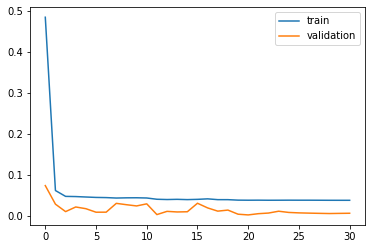


predict: [[30.9509083  23.25307116]]
real:      [[30.5 23.6]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4150 - mean_squared_error: 0.3196 - val_loss: 0.1107 - val_mean_squared_error: 0.0143
Epoch 2/1000
 - 0s - loss: 0.0695 - mean_squared_error: 0.0090 - val_loss: 0.0237 - val_mean_squared_error: 0.0010
Epoch 3/1000
 - 0s - loss: 0.0521 - mean_squared_error: 0.0046 - val_loss: 0.0185 - val_mean_squared_error: 3.4137e-04
Epoch 4/1000
 - 0s - loss: 0.0486 - mean_squared_error: 0.0041 - val_loss: 0.0212 - val_mean_squared_error: 4.5111e-04
Epoch 5/1000
 - 0s - loss: 0.0465 - mean_squared_error: 0.0038 - val_loss: 0.0226 - val_mean_squared_error: 5.6359e-04
Epoch 6/1000
 - 0s - loss: 0.0455 - mean_squared_error: 0.0036 - val_loss: 0.0155 - val_mean_squared_error: 3.1959e-04
Epoch 7/1000
 - 0s - loss: 0.0428 - mean_squared_error: 0.0033 - val_loss: 0.0171 - val_mean_squared_error: 2.9820e-04
Epoch 8/1000
 - 0s - loss: 0.0419 - mean_squared_error: 0.0031 - v

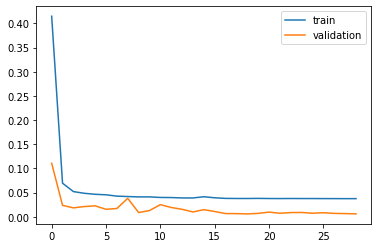


predict: [[31.12458624 23.23703804]]
real:      [[30.8 23.3]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3198 - mean_squared_error: 0.2044 - val_loss: 0.1097 - val_mean_squared_error: 0.0144
Epoch 2/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0067 - val_loss: 0.0101 - val_mean_squared_error: 1.7312e-04
Epoch 3/1000
 - 0s - loss: 0.0482 - mean_squared_error: 0.0041 - val_loss: 0.0055 - val_mean_squared_error: 5.3956e-05
Epoch 4/1000
 - 0s - loss: 0.0467 - mean_squared_error: 0.0039 - val_loss: 0.0117 - val_mean_squared_error: 1.5015e-04
Epoch 5/1000
 - 0s - loss: 0.0461 - mean_squared_error: 0.0037 - val_loss: 0.0065 - val_mean_squared_error: 8.3814e-05
Epoch 6/1000
 - 0s - loss: 0.0431 - mean_squared_error: 0.0033 - val_loss: 0.0217 - val_mean_squared_error: 4.6923e-04
Epoch 7/1000
 - 0s - loss: 0.0406 - mean_squared_error: 0.0029 - val_loss: 0.0106 - val_mean_squared_error: 1.7476e-04
Epoch 8/1000
 - 1s - loss: 0.0395 - mean_squared_error: 0.0029

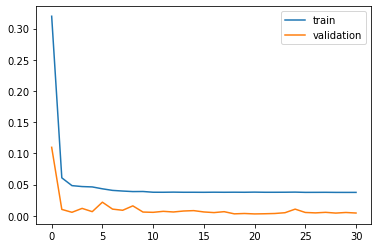


predict: [[31.34091429 23.25350337]]
real:      [[31.  23.4]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2570 - mean_squared_error: 0.1319 - val_loss: 0.1013 - val_mean_squared_error: 0.0115
Epoch 2/1000
 - 0s - loss: 0.0578 - mean_squared_error: 0.0057 - val_loss: 0.0346 - val_mean_squared_error: 0.0012
Epoch 3/1000
 - 1s - loss: 0.0470 - mean_squared_error: 0.0039 - val_loss: 0.0209 - val_mean_squared_error: 6.4959e-04
Epoch 4/1000
 - 0s - loss: 0.0456 - mean_squared_error: 0.0037 - val_loss: 0.0277 - val_mean_squared_error: 8.2170e-04
Epoch 5/1000
 - 1s - loss: 0.0446 - mean_squared_error: 0.0036 - val_loss: 0.0147 - val_mean_squared_error: 3.1511e-04
Epoch 6/1000
 - 0s - loss: 0.0442 - mean_squared_error: 0.0035 - val_loss: 0.0302 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 1s - loss: 0.0446 - mean_squared_error: 0.0036 - val_loss: 0.0350 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 1s - loss: 0.0433 - mean_squared_error: 0.0033 - val_loss:

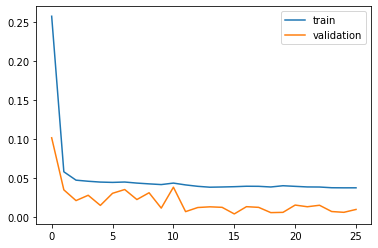


predict: [[31.57330007 22.93538105]]
real:      [[30.7 23.2]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2894 - mean_squared_error: 0.1791 - val_loss: 0.0381 - val_mean_squared_error: 0.0017
Epoch 2/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0059 - val_loss: 0.0358 - val_mean_squared_error: 0.0017
Epoch 3/1000
 - 0s - loss: 0.0497 - mean_squared_error: 0.0043 - val_loss: 0.0414 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0480 - mean_squared_error: 0.0041 - val_loss: 0.0568 - val_mean_squared_error: 0.0033
Epoch 5/1000
 - 1s - loss: 0.0462 - mean_squared_error: 0.0037 - val_loss: 0.0371 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 0s - loss: 0.0415 - mean_squared_error: 0.0031 - val_loss: 0.0459 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0396 - mean_squared_error: 0.0029 - val_loss: 0.0488 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 1s - loss: 0.0403 - mean_squared_error: 0.0030 - val_loss: 0.0332 - va

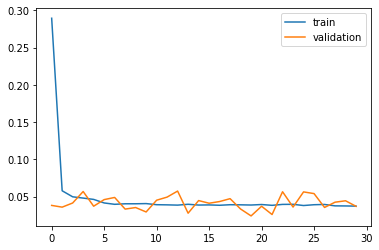


predict: [[31.90022953 23.03771423]]
real:      [[31.  22.7]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3063 - mean_squared_error: 0.2026 - val_loss: 0.0402 - val_mean_squared_error: 0.0016
Epoch 2/1000
 - 0s - loss: 0.0558 - mean_squared_error: 0.0053 - val_loss: 0.0294 - val_mean_squared_error: 8.8946e-04
Epoch 3/1000
 - 0s - loss: 0.0486 - mean_squared_error: 0.0041 - val_loss: 0.0252 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 0s - loss: 0.0467 - mean_squared_error: 0.0038 - val_loss: 0.0384 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 1s - loss: 0.0456 - mean_squared_error: 0.0036 - val_loss: 0.0267 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 0s - loss: 0.0452 - mean_squared_error: 0.0036 - val_loss: 0.0206 - val_mean_squared_error: 7.5216e-04
Epoch 7/1000
 - 0s - loss: 0.0451 - mean_squared_error: 0.0036 - val_loss: 0.0358 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 0s - loss: 0.0438 - mean_squared_error: 0.0034 - val_loss: 0.0

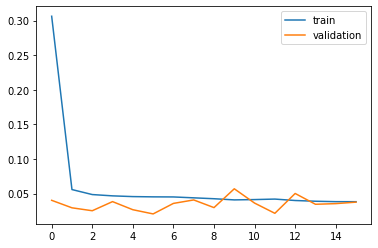


predict: [[29.59255254 22.47034961]]
real:      [[31.6 21.9]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3606 - mean_squared_error: 0.2483 - val_loss: 0.0133 - val_mean_squared_error: 3.3347e-04
Epoch 2/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0058 - val_loss: 0.0693 - val_mean_squared_error: 0.0080
Epoch 3/1000
 - 1s - loss: 0.0483 - mean_squared_error: 0.0041 - val_loss: 0.0363 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 0s - loss: 0.0454 - mean_squared_error: 0.0037 - val_loss: 0.0446 - val_mean_squared_error: 0.0024
Epoch 5/1000
 - 1s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0431 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 1s - loss: 0.0412 - mean_squared_error: 0.0031 - val_loss: 0.0310 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 0s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0294 - val_mean_squared_error: 8.8443e-04
Epoch 8/1000
 - 1s - loss: 0.0414 - mean_squared_error: 0.0031 - val_loss: 0.0

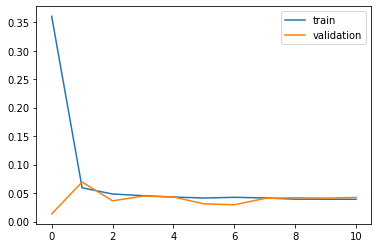


predict: [[28.39680391 22.13978186]]
real:      [[29.2 22.6]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4469 - mean_squared_error: 0.3587 - val_loss: 0.0837 - val_mean_squared_error: 0.0072
Epoch 2/1000
 - 1s - loss: 0.0661 - mean_squared_error: 0.0082 - val_loss: 0.0738 - val_mean_squared_error: 0.0057
Epoch 3/1000
 - 1s - loss: 0.0506 - mean_squared_error: 0.0046 - val_loss: 0.0499 - val_mean_squared_error: 0.0025
Epoch 4/1000
 - 1s - loss: 0.0462 - mean_squared_error: 0.0038 - val_loss: 0.0596 - val_mean_squared_error: 0.0036
Epoch 5/1000
 - 1s - loss: 0.0445 - mean_squared_error: 0.0036 - val_loss: 0.0519 - val_mean_squared_error: 0.0033
Epoch 6/1000
 - 1s - loss: 0.0442 - mean_squared_error: 0.0035 - val_loss: 0.0443 - val_mean_squared_error: 0.0020
Epoch 7/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0031 - val_loss: 0.0473 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 1s - loss: 0.0410 - mean_squared_error: 0.0030 - val_loss: 0.0453 - va

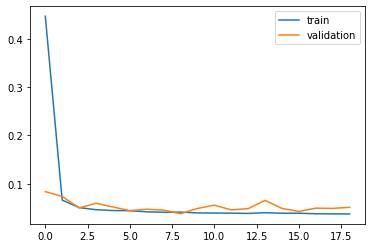


predict: [[31.10871726 22.80197055]]
real:      [[28.6 23.1]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3140 - mean_squared_error: 0.2003 - val_loss: 0.0792 - val_mean_squared_error: 0.0063
Epoch 2/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0055 - val_loss: 0.0502 - val_mean_squared_error: 0.0025
Epoch 3/1000
 - 0s - loss: 0.0491 - mean_squared_error: 0.0042 - val_loss: 0.0586 - val_mean_squared_error: 0.0035
Epoch 4/1000
 - 0s - loss: 0.0471 - mean_squared_error: 0.0039 - val_loss: 0.0498 - val_mean_squared_error: 0.0025
Epoch 5/1000
 - 0s - loss: 0.0458 - mean_squared_error: 0.0037 - val_loss: 0.0467 - val_mean_squared_error: 0.0022
Epoch 6/1000
 - 0s - loss: 0.0447 - mean_squared_error: 0.0035 - val_loss: 0.0463 - val_mean_squared_error: 0.0024
Epoch 7/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0033 - val_loss: 0.0432 - val_mean_squared_error: 0.0020
Epoch 8/1000
 - 0s - loss: 0.0415 - mean_squared_error: 0.0031 - val_loss: 0.0601 - va

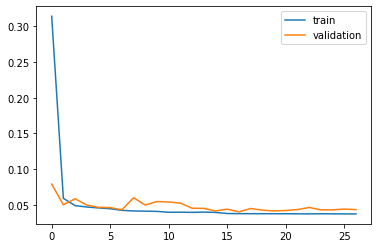


predict: [[31.42337773 23.2492359 ]]
real:      [[31.6 21.8]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4113 - mean_squared_error: 0.3632 - val_loss: 0.1207 - val_mean_squared_error: 0.0211
Epoch 2/1000
 - 0s - loss: 0.0686 - mean_squared_error: 0.0091 - val_loss: 0.0354 - val_mean_squared_error: 0.0016
Epoch 3/1000
 - 1s - loss: 0.0496 - mean_squared_error: 0.0043 - val_loss: 0.0085 - val_mean_squared_error: 1.0937e-04
Epoch 4/1000
 - 1s - loss: 0.0477 - mean_squared_error: 0.0040 - val_loss: 0.0104 - val_mean_squared_error: 1.5902e-04
Epoch 5/1000
 - 0s - loss: 0.0466 - mean_squared_error: 0.0038 - val_loss: 0.0060 - val_mean_squared_error: 3.7180e-05
Epoch 6/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0036 - val_loss: 0.0090 - val_mean_squared_error: 1.0417e-04
Epoch 7/1000
 - 0s - loss: 0.0406 - mean_squared_error: 0.0030 - val_loss: 0.0282 - val_mean_squared_error: 9.4612e-04
Epoch 8/1000
 - 1s - loss: 0.0399 - mean_squared_error: 0.0029 - v

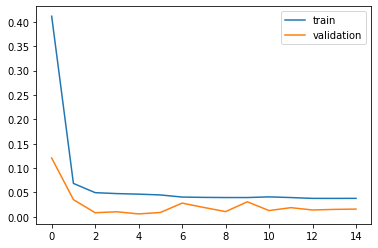


predict: [[29.95386525 22.88844432]]
real:      [[31.8 22. ]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4117 - mean_squared_error: 0.3713 - val_loss: 0.0493 - val_mean_squared_error: 0.0037
Epoch 2/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0082 - val_loss: 0.0105 - val_mean_squared_error: 2.1498e-04
Epoch 3/1000
 - 1s - loss: 0.0486 - mean_squared_error: 0.0042 - val_loss: 0.0179 - val_mean_squared_error: 3.7415e-04
Epoch 4/1000
 - 1s - loss: 0.0472 - mean_squared_error: 0.0040 - val_loss: 0.0290 - val_mean_squared_error: 8.8434e-04
Epoch 5/1000
 - 1s - loss: 0.0471 - mean_squared_error: 0.0039 - val_loss: 0.0183 - val_mean_squared_error: 4.6310e-04
Epoch 6/1000
 - 1s - loss: 0.0461 - mean_squared_error: 0.0038 - val_loss: 0.0155 - val_mean_squared_error: 2.9024e-04
Epoch 7/1000
 - 0s - loss: 0.0458 - mean_squared_error: 0.0038 - val_loss: 0.0117 - val_mean_squared_error: 1.4323e-04
Epoch 8/1000
 - 0s - loss: 0.0451 - mean_squared_error: 0.0037

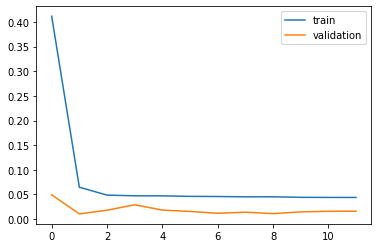


predict: [[30.16784618 22.63933743]]
real:      [[30.4 23. ]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3138 - mean_squared_error: 0.2170 - val_loss: 0.0999 - val_mean_squared_error: 0.0162
Epoch 2/1000
 - 1s - loss: 0.0553 - mean_squared_error: 0.0054 - val_loss: 0.0248 - val_mean_squared_error: 6.6327e-04
Epoch 3/1000
 - 0s - loss: 0.0477 - mean_squared_error: 0.0041 - val_loss: 0.0550 - val_mean_squared_error: 0.0037
Epoch 4/1000
 - 1s - loss: 0.0464 - mean_squared_error: 0.0039 - val_loss: 0.0396 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0452 - mean_squared_error: 0.0036 - val_loss: 0.0349 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 1s - loss: 0.0453 - mean_squared_error: 0.0036 - val_loss: 0.0610 - val_mean_squared_error: 0.0037
Epoch 7/1000
 - 1s - loss: 0.0459 - mean_squared_error: 0.0037 - val_loss: 0.0384 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0433 - mean_squared_error: 0.0034 - val_loss: 0.0359 

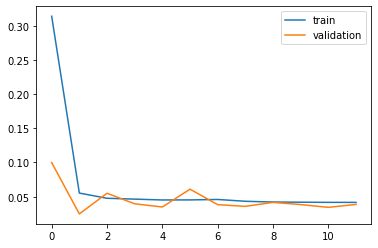


predict: [[30.71973164 22.99250364]]
real:      [[30.8 22.5]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5456 - mean_squared_error: 0.4650 - val_loss: 0.1208 - val_mean_squared_error: 0.0189
Epoch 2/1000
 - 0s - loss: 0.0707 - mean_squared_error: 0.0086 - val_loss: 0.0244 - val_mean_squared_error: 9.0528e-04
Epoch 3/1000
 - 0s - loss: 0.0498 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 6.5519e-06
Epoch 4/1000
 - 1s - loss: 0.0472 - mean_squared_error: 0.0040 - val_loss: 0.0053 - val_mean_squared_error: 2.9937e-05
Epoch 5/1000
 - 1s - loss: 0.0452 - mean_squared_error: 0.0037 - val_loss: 0.0121 - val_mean_squared_error: 1.5838e-04
Epoch 6/1000
 - 0s - loss: 0.0441 - mean_squared_error: 0.0035 - val_loss: 0.0158 - val_mean_squared_error: 2.7360e-04
Epoch 7/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0305 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.0424 - mean_squared_error: 0.0033 - v

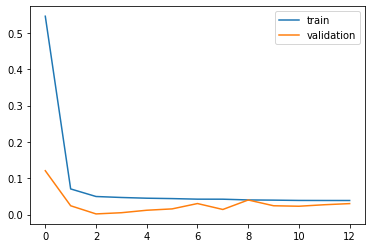


predict: [[29.74303294 22.46015145]]
real:      [[31.8 23.8]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8781 - mean_squared_error: 1.0363 - val_loss: 0.1843 - val_mean_squared_error: 0.0428
Epoch 2/1000
 - 1s - loss: 0.0870 - mean_squared_error: 0.0129 - val_loss: 0.0619 - val_mean_squared_error: 0.0040
Epoch 3/1000
 - 0s - loss: 0.0514 - mean_squared_error: 0.0047 - val_loss: 0.0283 - val_mean_squared_error: 8.0391e-04
Epoch 4/1000
 - 1s - loss: 0.0474 - mean_squared_error: 0.0041 - val_loss: 0.0244 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 0s - loss: 0.0469 - mean_squared_error: 0.0039 - val_loss: 0.0173 - val_mean_squared_error: 5.3177e-04
Epoch 6/1000
 - 0s - loss: 0.0449 - mean_squared_error: 0.0037 - val_loss: 0.0175 - val_mean_squared_error: 3.3589e-04
Epoch 7/1000
 - 1s - loss: 0.0440 - mean_squared_error: 0.0035 - val_loss: 0.0172 - val_mean_squared_error: 3.0613e-04
Epoch 8/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0034 - val_l

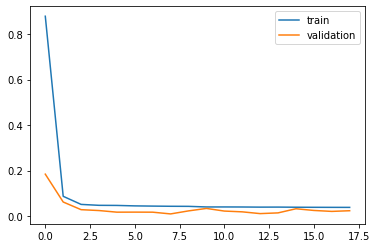


predict: [[30.55226342 23.54704533]]
real:      [[29.9 22.7]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5080 - mean_squared_error: 0.3781 - val_loss: 0.0985 - val_mean_squared_error: 0.0133
Epoch 2/1000
 - 1s - loss: 0.0799 - mean_squared_error: 0.0119 - val_loss: 0.0223 - val_mean_squared_error: 5.6419e-04
Epoch 3/1000
 - 1s - loss: 0.0514 - mean_squared_error: 0.0048 - val_loss: 0.0501 - val_mean_squared_error: 0.0042
Epoch 4/1000
 - 1s - loss: 0.0472 - mean_squared_error: 0.0039 - val_loss: 0.0592 - val_mean_squared_error: 0.0058
Epoch 5/1000
 - 1s - loss: 0.0461 - mean_squared_error: 0.0038 - val_loss: 0.0629 - val_mean_squared_error: 0.0058
Epoch 6/1000
 - 1s - loss: 0.0453 - mean_squared_error: 0.0037 - val_loss: 0.0467 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.0455 - mean_squared_error: 0.0037 - val_loss: 0.0682 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 1s - loss: 0.0454 - mean_squared_error: 0.0037 - val_loss: 0.0525 

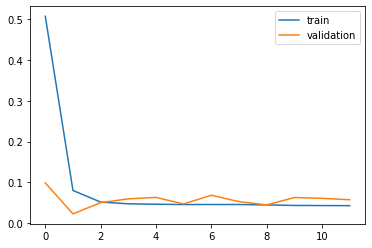


predict: [[31.97311304 22.98153131]]
real:      [[30.6 23.5]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4194 - mean_squared_error: 0.3565 - val_loss: 0.1813 - val_mean_squared_error: 0.0338
Epoch 2/1000
 - 1s - loss: 0.0694 - mean_squared_error: 0.0078 - val_loss: 0.0534 - val_mean_squared_error: 0.0040
Epoch 3/1000
 - 1s - loss: 0.0518 - mean_squared_error: 0.0046 - val_loss: 0.0766 - val_mean_squared_error: 0.0087
Epoch 4/1000
 - 1s - loss: 0.0481 - mean_squared_error: 0.0041 - val_loss: 0.0591 - val_mean_squared_error: 0.0049
Epoch 5/1000
 - 1s - loss: 0.0467 - mean_squared_error: 0.0039 - val_loss: 0.0450 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 1s - loss: 0.0459 - mean_squared_error: 0.0038 - val_loss: 0.0577 - val_mean_squared_error: 0.0042
Epoch 7/1000
 - 1s - loss: 0.0445 - mean_squared_error: 0.0036 - val_loss: 0.0578 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0688 - va

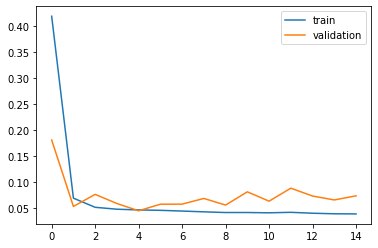


predict: [[31.0576088  22.65070779]]
real:      [[32.8 23.4]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5189 - mean_squared_error: 0.4433 - val_loss: 0.0761 - val_mean_squared_error: 0.0065
Epoch 2/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0070 - val_loss: 0.0450 - val_mean_squared_error: 0.0023
Epoch 3/1000
 - 1s - loss: 0.0466 - mean_squared_error: 0.0039 - val_loss: 0.0587 - val_mean_squared_error: 0.0041
Epoch 4/1000
 - 0s - loss: 0.0455 - mean_squared_error: 0.0037 - val_loss: 0.0583 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 1s - loss: 0.0446 - mean_squared_error: 0.0036 - val_loss: 0.0569 - val_mean_squared_error: 0.0038
Epoch 6/1000
 - 1s - loss: 0.0431 - mean_squared_error: 0.0033 - val_loss: 0.0413 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0031 - val_loss: 0.0443 - val_mean_squared_error: 0.0022
Epoch 8/1000
 - 1s - loss: 0.0401 - mean_squared_error: 0.0029 - val_loss: 0.0482 - va

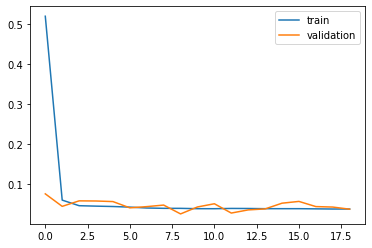


predict: [[31.68156531 23.42357311]]
real:      [[33.4 23.6]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6614 - mean_squared_error: 0.6491 - val_loss: 0.1523 - val_mean_squared_error: 0.0249
Epoch 2/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0068 - val_loss: 0.0857 - val_mean_squared_error: 0.0116
Epoch 3/1000
 - 1s - loss: 0.0471 - mean_squared_error: 0.0040 - val_loss: 0.0632 - val_mean_squared_error: 0.0058
Epoch 4/1000
 - 1s - loss: 0.0458 - mean_squared_error: 0.0037 - val_loss: 0.0986 - val_mean_squared_error: 0.0155
Epoch 5/1000
 - 1s - loss: 0.0440 - mean_squared_error: 0.0035 - val_loss: 0.1131 - val_mean_squared_error: 0.0171
Epoch 6/1000
 - 1s - loss: 0.0444 - mean_squared_error: 0.0035 - val_loss: 0.0682 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 1s - loss: 0.0435 - mean_squared_error: 0.0033 - val_loss: 0.0952 - val_mean_squared_error: 0.0109
Epoch 8/1000
 - 1s - loss: 0.0420 - mean_squared_error: 0.0032 - val_loss: 0.0717 - va

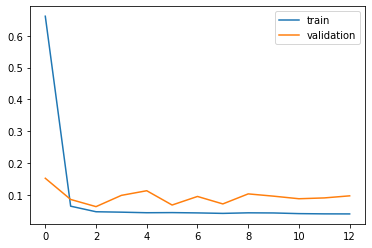


predict: [[31.4736409  23.23386479]]
real:      [[32.2 23.8]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3482 - mean_squared_error: 0.2335 - val_loss: 0.0288 - val_mean_squared_error: 9.6278e-04
Epoch 2/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0059 - val_loss: 0.0716 - val_mean_squared_error: 0.0056
Epoch 3/1000
 - 1s - loss: 0.0474 - mean_squared_error: 0.0039 - val_loss: 0.0346 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 1s - loss: 0.0458 - mean_squared_error: 0.0037 - val_loss: 0.0397 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0036 - val_loss: 0.0479 - val_mean_squared_error: 0.0023
Epoch 6/1000
 - 1s - loss: 0.0450 - mean_squared_error: 0.0036 - val_loss: 0.0508 - val_mean_squared_error: 0.0029
Epoch 7/1000
 - 1s - loss: 0.0435 - mean_squared_error: 0.0034 - val_loss: 0.0291 - val_mean_squared_error: 8.4816e-04
Epoch 8/1000
 - 1s - loss: 0.0435 - mean_squared_error: 0.0034 - val_loss: 0.0

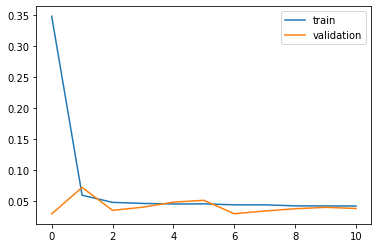


predict: [[32.64792086 23.59807719]]
real:      [[34.  23.7]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8347 - mean_squared_error: 0.8063 - val_loss: 0.1450 - val_mean_squared_error: 0.0270
Epoch 2/1000
 - 1s - loss: 0.0798 - mean_squared_error: 0.0117 - val_loss: 0.0302 - val_mean_squared_error: 0.0011
Epoch 3/1000
 - 1s - loss: 0.0491 - mean_squared_error: 0.0044 - val_loss: 0.0412 - val_mean_squared_error: 0.0022
Epoch 4/1000
 - 0s - loss: 0.0466 - mean_squared_error: 0.0039 - val_loss: 0.0407 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 1s - loss: 0.0457 - mean_squared_error: 0.0037 - val_loss: 0.0455 - val_mean_squared_error: 0.0022
Epoch 6/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0036 - val_loss: 0.0322 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 1s - loss: 0.0435 - mean_squared_error: 0.0034 - val_loss: 0.0497 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0033 - val_loss: 0.0333 - va

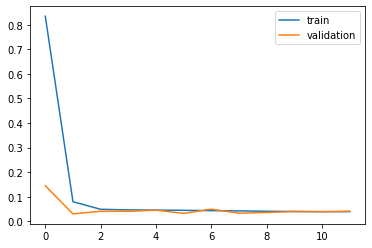


predict: [[30.48074222 23.05861117]]
real:      [[31.6 23.7]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6000 - mean_squared_error: 0.6513 - val_loss: 0.0821 - val_mean_squared_error: 0.0093
Epoch 2/1000
 - 1s - loss: 0.0716 - mean_squared_error: 0.0099 - val_loss: 0.0028 - val_mean_squared_error: 1.3074e-05
Epoch 3/1000
 - 1s - loss: 0.0502 - mean_squared_error: 0.0045 - val_loss: 0.0257 - val_mean_squared_error: 8.0788e-04
Epoch 4/1000
 - 1s - loss: 0.0482 - mean_squared_error: 0.0041 - val_loss: 0.0160 - val_mean_squared_error: 4.0152e-04
Epoch 5/1000
 - 1s - loss: 0.0471 - mean_squared_error: 0.0040 - val_loss: 0.0234 - val_mean_squared_error: 5.6834e-04
Epoch 6/1000
 - 1s - loss: 0.0464 - mean_squared_error: 0.0039 - val_loss: 0.0096 - val_mean_squared_error: 1.3686e-04
Epoch 7/1000
 - 1s - loss: 0.0461 - mean_squared_error: 0.0038 - val_loss: 0.0264 - val_mean_squared_error: 6.9928e-04
Epoch 8/1000
 - 1s - loss: 0.0453 - mean_squared_error: 0.0037

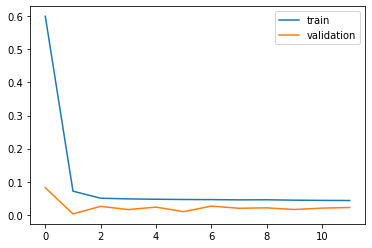


predict: [[29.54886292 23.14553905]]
real:      [[31.6 23.4]]

Train on 1734 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8022 - mean_squared_error: 0.7883 - val_loss: 0.2091 - val_mean_squared_error: 0.0560
Epoch 2/1000
 - 1s - loss: 0.1065 - mean_squared_error: 0.0178 - val_loss: 0.0540 - val_mean_squared_error: 0.0030
Epoch 3/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0056 - val_loss: 0.0292 - val_mean_squared_error: 8.8828e-04
Epoch 4/1000
 - 1s - loss: 0.0491 - mean_squared_error: 0.0043 - val_loss: 0.0272 - val_mean_squared_error: 7.6451e-04
Epoch 5/1000
 - 1s - loss: 0.0470 - mean_squared_error: 0.0039 - val_loss: 0.0093 - val_mean_squared_error: 1.1396e-04
Epoch 6/1000
 - 1s - loss: 0.0443 - mean_squared_error: 0.0035 - val_loss: 0.0451 - val_mean_squared_error: 0.0020
Epoch 7/1000
 - 1s - loss: 0.0429 - mean_squared_error: 0.0033 - val_loss: 0.0169 - val_mean_squared_error: 4.5040e-04
Epoch 8/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0032 - val_l

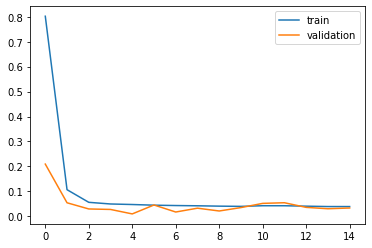


predict: [[29.71091473 22.79771812]]
real:      [[29.9 23.3]]

Train on 1733 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9910 - mean_squared_error: 1.4008 - val_loss: 0.6410 - val_mean_squared_error: 0.8022
Epoch 2/1000
 - 1s - loss: 0.2522 - mean_squared_error: 0.1625 - val_loss: 0.0530 - val_mean_squared_error: 0.0033
Epoch 3/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0065 - val_loss: 0.0740 - val_mean_squared_error: 0.0067
Epoch 4/1000
 - 1s - loss: 0.0487 - mean_squared_error: 0.0042 - val_loss: 0.0512 - val_mean_squared_error: 0.0029
Epoch 5/1000
 - 1s - loss: 0.0468 - mean_squared_error: 0.0038 - val_loss: 0.0437 - val_mean_squared_error: 0.0025
Epoch 6/1000
 - 1s - loss: 0.0458 - mean_squared_error: 0.0037 - val_loss: 0.0537 - val_mean_squared_error: 0.0035
Epoch 7/1000
 - 1s - loss: 0.0465 - mean_squared_error: 0.0038 - val_loss: 0.0400 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 1s - loss: 0.0456 - mean_squared_error: 0.0036 - val_loss: 0.0497 - va

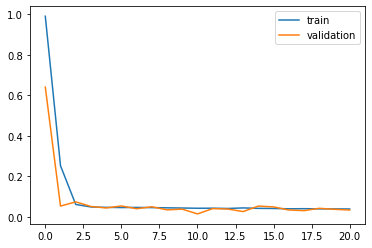


predict: [[31.53484358 22.88649934]]
real:      [[29.9 22.6]]

Train and validation time: 6.545399471124013

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 1.783
Test STANDART-DEVIATION ------------ 0.7113
Test MEAN-ABSOLUTE-ERROR ----------- 1.13
Test MEDIAN-ABSOLUTE-ERROR --------- 1.17

Errors
2018-12-31 = 1.220344390741893
2018-12-30 = 0.5245992997867504
2018-12-29 = 2.3070034918307485
2018-12-28 = 1.5406989012707974
2018-12-27 = 1.4401380127673455
2018-12-26 = 1.5530200589717182
2018-12-25 = 0.15724214130227665
2018-12-24 = 0.45090830330660836
2018-12-23 = 0.3245862419686425
2018-12-22 = 0.340914289179878
2018-12-21 = 0.8733000708009477
2018-12-20 = 0.9002295251542805
2018-12-19 = 2.0074474564679754
2018-12-18 = 0.8031960869768717
2018-12-17 = 2.5087172611660087
2018-12-16 = 0.17662226894882238
2018-12-15 = 1.846134754449011
2018-12-14 = 0.23215381730994267
2018-12-13 = 0.08026836100455981
2018-12-12 = 2.056967062575172
2018-12-11 = 0.6522634204544175
2018-12-1

In [16]:
def main():
    input_path = '../data_in/'+city+'.csv'
    output_path = format_dataset(input_path)
    dataset = load_dataset(output_path)
    values = dataset.values
    plot_columns(dataset, values)

    # to get index the last 30 days
    days_to_predict = list(dataset.index[-30:])

    mean_scaler = np.mean(values) + 1
    dataset_scaled = dataset.div(mean_scaler)

    inicio = time.time()
    result = NCV(dataset_scaled, days_to_predict, mean_scaler)
    fim = time.time()
    print('Train and validation time: {}\n'.format((fim - inicio)/60))

    y_hats = result[0]
    y_tests = result[1]

    metrics(y_hats, y_tests, days_to_predict)
    
if __name__ == "__main__":
    main()